In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import numpy as np
from src.model.reconstruction import MemAutoEncoder, DAGMM
from src.model.one_class import DeepSVDD
from src.trainer.ids import MemAEIDSTrainer, DAGMMIDSTrainer, DeepSVDDIDSTrainer
from src.datamanager.dataset import IDS2018Dataset
from pathlib import Path

In [2]:
# Setup base folder structure
dataset_path = "../../data/IDS2018/ids2018.csv"
#dataset_path = "C:/Users/verdi/Documents/Datasets/IDS2018/3_minified/feature_group_5A.npz"
base_path = Path("./ids2018")
base_path.mkdir(exist_ok=True)

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 50
thresh_mode = "auto"

print("arguments set")

arguments set


## Load data

In [3]:
dataset = IDS2018Dataset(path=dataset_path)#, pct=0.5, seed=13)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=13)
print("data loaded with shape {}".format(dataset.shape))

# Use Arrhythmia for testing before launching a training session on the much larger IDS2018 dataset
# from src.datamanager.dataset import ArrhythmiaDataset
# dataset = ArrhythmiaDataset(path="C:\\Users\\verdi\\Documents\\Datasets\\Arrhythmia\\3_minified\\arrhythmia_normalized.npz")
# batch_size = 8
# train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
# print("data loaded with shape {}".format(dataset.shape()))

data loaded with shape (16232928, 66)


In [4]:
np.unique(dataset.labels)

array(['Benign', 'Bot', 'DDoS', 'DoS', 'FTP-BruteForce', 'Infiltration',
       'SSH-Bruteforce', 'Web Attack'], dtype=object)

## DeepSVDD Training

Initializing center c...
Center c initialized.
Epoch=0	Loss=0.0017
Epoch=10	Loss=0.0000
Epoch=20	Loss=0.0000
Epoch=30	Loss=0.0000
Epoch=40	Loss=0.0000


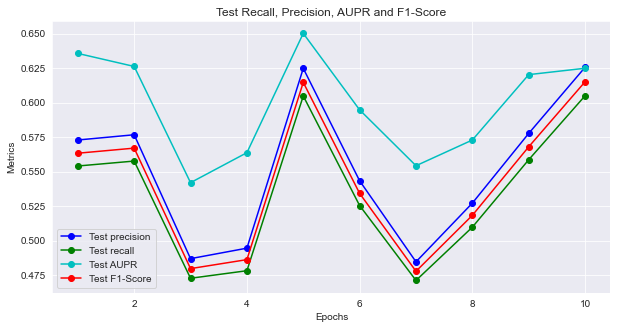

In [5]:
# Create folder structure
export_path = base_path.joinpath("deepsvdd")
ckpt_path = export_path.joinpath("checkpoint")
ckpt_path.mkdir(parents=True, exist_ok=True)

# Setup model and trainer
dsvdd_model = DeepSVDD(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn=act_fn,
)
dsvdd_trainer = DeepSVDDIDSTrainer(
    validation_ldr=test_ldr,
    model=dsvdd_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    device=device,
    ckpt_root=str(ckpt_path.absolute()),
    run_test_validation=True,
    keep_ckpt=True,
    thresh_mode=thresh_mode
)
# Train and plot validation set
dsvdd_trainer.train(train_ldr)
figname = str(export_path.absolute()) + "\\IDS2018_thresh-auto.png"
dsvdd_trainer.plot_metrics(figname=figname)

In [ ]:
# Save memory
del dsvdd_trainer
del dsvdd_model

## DAGMM Training

In [6]:
# Create folder structure
export_path = base_path.joinpath("dagmm")
ckpt_path = export_path.joinpath("checkpoint")
ckpt_path.mkdir(parents=True, exist_ok=True)

# Set DAGMM-specific hyperparameters
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

# Setup model and trainers
dagmm_model = DAGMM(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_mixtures=n_mixtures,
    latent_dim=latent_dim,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    reg_covar=reg_covar,
    n_layers=n_layers,
    compression_factor=compression_factor,
    ae_act_fn="relu",
    gmm_act_fn="relu"
)
dagmm_trainer = DAGMMIDSTrainer(
    validation_ldr=test_ldr,
    device=device,
    model=dagmm_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_root=str(ckpt_path.absolute()),
    run_test_validation=True,
    thresh_mode=thresh_mode
)
# Train and plot validation set
dagmm_trainer.train(train_ldr)
figname = str(export_path.absolute()) + "\\IDS2018_thresh-auto.png"
dagmm_trainer.plot_metrics(figname=figname)

KeyboardInterrupt: 

In [11]:
# Save memory
del dagmm_model
del dagmm_trainer

## MemAE training

Epoch=0	Loss=55.5743
Epoch=10	Loss=6.7053
Epoch=20	Loss=5.5429
Epoch=30	Loss=4.9634
Epoch=40	Loss=4.6767
Epoch=50	Loss=4.2679
Epoch=60	Loss=3.9754
Epoch=70	Loss=3.8335
Epoch=80	Loss=3.7346
Epoch=90	Loss=3.6490
Epoch=100	Loss=3.5687
Epoch=110	Loss=3.4589
Epoch=120	Loss=3.3814
Epoch=130	Loss=3.3114
Epoch=140	Loss=3.2483
Epoch=150	Loss=3.1912
Epoch=160	Loss=3.1378
Epoch=170	Loss=3.0902
Epoch=180	Loss=3.0464
Epoch=190	Loss=3.0040


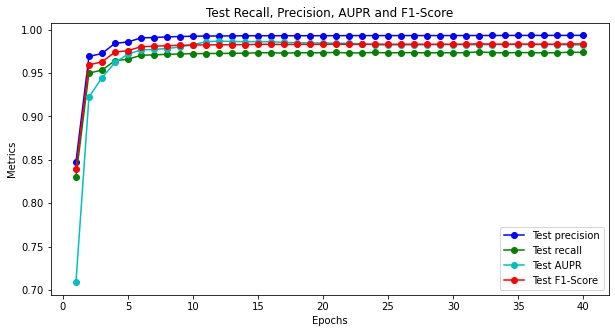

In [12]:
# Create folder structure
export_path = base_path.joinpath("memae")
ckpt_path = export_path.joinpath("checkpoint")
ckpt_path.mkdir(parents=True, exist_ok=True)

# Set MemAE-specific hyperparameters
latent_dim = 1
mem_dim = 50
shrink_thres = 0.0025
n_layers = 4
compression_factor = 2
act_fn = "relu"
alpha = 2e-4

# Setup model and trainers
memae_model = MemAutoEncoder(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    mem_dim=mem_dim,
    latent_dim=latent_dim,
    shrink_thres=shrink_thres,
    n_layers=n_layers,
    compression_factor=2,
    alpha=2e-4,
    act_fn="relu",
)
memae_trainer = MemAEIDSTrainer(
    validation_ldr=test_ldr,
    device=device,
    model=memae_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_root=str(ckpt_path.absolute()),
    run_test_validation=True,
    keep_ckpt=True,
    thresh_mode=thresh_mode
)
# Train and plot validation set
memae_trainer.train(train_ldr)
figname = str(export_path.absolute()) + "\\IDS2018_thresh-auto.png"
memae_trainer.plot_metrics(figname=figname)

In [13]:
del memae_model
del memae_trainer